# SILC Tutorial

## 🌌 SILC Pipeline Overview

The **Scale-discretised, directional Internal Linear Combination (SILC)** pipeline performs component separation in CMB analysis. 

### 🔄 Pipeline

| Step | Process | Description |
|------|---------|-------------|
| **1️⃣** | **🔽 Data Acquisition** | Download CMB, noise, and foreground maps, currently using Planck simulations  → `download.py` |
| **2️⃣** | **⚙️ Map Processing** | Handle instrumental beams, reduce resolution, and convert from HEALPix → McEwen-Wiaux (MW) sampling  → `map_tools.py` `map_processing.py`|
| **3️⃣** | **〰️ Wavelet Analysis** | Apply multi-scale wavelet transforms with customizable filter scales and directional components  → `map_processing.py` |
| **4️⃣** | **⚖️ SPIN Algorithm** | Compute Scale-discretised, directional Internal Linear Combination on each wavelet scale  → `ilc.py` |
| **5️⃣** | **🔧 Map Synthesis** | Combine all scales into a single, clean ILC component map  → `ilc.py` |

- `visualise.py` module provides capability to compute and plot maps and power spectra. 
- `file_templates.py` module contains the directory structure for storing and loading data throughout the pipeline.

### 🎯 Current Capabilities

> **Primary Target**: CMB extraction 

> **Future Expansion**: Generalization to extract any astrophysical component (e.g., thermal Sunyaev-Zel'dovich effect, synchrotron emission, dust)

This notebook will decompose the pipeline to show the main processes occurring at each stage, for one realisation of the ILC.

## 📦 Import 

**Note:** To run modules in the terminal, use e.g. `python3 -m skyclean.silc.map_processing` while in the Skyclean home directory.

In [12]:
import sys
import os
from matplotlib import pyplot as plt
import numpy as np
import healpy as hp
import jax

# Add the parent directory to Python path for proper module resolution
# Get current working directory and navigate to parent (assumes notebook is in examples/ folder)
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

print(f"Current directory: {current_dir}")
print(f"Added to Python path: {parent_dir}")

# Check JAX devices
print(f"\nJAX Configuration:")
print(f"JAX devices available: {jax.devices()}")
print(f"JAX default backend: {jax.default_backend()}")
print(f"JAX version: {jax.__version__}")

# Import SILC modules
from skyclean.silc.download import DownloadData
from skyclean.silc.file_templates import FileTemplates
from skyclean.silc.map_tools import MWTools, HPTools, SamplingConverters
from skyclean.silc.map_processing import ProcessMaps
from skyclean.silc.ilc import SILCTools, ProduceSILC
from skyclean.silc.pipeline import Pipeline
from skyclean.silc.utils import *
from skyclean.silc.visualise import Visualise

print("All SILC modules successfully imported!")
print("Available classes:")
print("  - DownloadData: Download CMB, noise, and foreground maps")
print("  - FileTemplates: Manage file paths and directory structure")
print("  - HPTools: Tools for processing HEALPix maps")
print("  - MWTools: Tools for McEwen-Wiaux sampling and wavelet transforms")
print("  - SamplingConverters: Convert between HEALPix and MW sampling")
print("  - ProcessMaps: Process downloaded maps and create CFNs")
print("  - SILCTools: Core SILC algorithm tools")
print("  - ProduceSILC: Generate ILC maps using SILC")
print("  - Pipeline: Run complete SILC pipeline")
print("  - Visualise: Plotting and visualization tools")

Current directory: /home/matthew/Skyclean/examples
Added to Python path: /home/matthew/Skyclean

JAX Configuration:
JAX devices available: [CudaDevice(id=0), CudaDevice(id=1)]
JAX default backend: gpu
JAX version: 0.5.3
All SILC modules successfully imported!
Available classes:
  - DownloadData: Download CMB, noise, and foreground maps
  - FileTemplates: Manage file paths and directory structure
  - HPTools: Tools for processing HEALPix maps
  - MWTools: Tools for McEwen-Wiaux sampling and wavelet transforms
  - SamplingConverters: Convert between HEALPix and MW sampling
  - ProcessMaps: Process downloaded maps and create CFNs
  - SILCTools: Core SILC algorithm tools
  - ProduceSILC: Generate ILC maps using SILC
  - Pipeline: Run complete SILC pipeline
  - Visualise: Plotting and visualization tools


## ⬇️ Download 

Skyclean currently downloads maps from the [Planck simulation archive](https://pla.esac.esa.int/#home). The downloaded maps include noise and foregrounds. The noise maps have a total of 300 random realisations. 

A problem was encountered with the Planck CMB simulations where the instrumental beams produced different maps in different frequency channels when deconvolved. This breaks the ILC assumption that the CMB is frequency channel-independent. Thus, a new approach was decided on where `cmb_spectrum.txt` is used to generate random CMB realisations. Make sure this is in your data directory before running downloads. 

In [13]:
## INITIALISE PARAMS

# Initialize file templates
data_directory = "data/"   # Local data storage
files = FileTemplates(data_directory)
file_templates = files.file_templates

# Define components to download
components = ["cmb", "sync", "dust", "noise"]

# Define frequencies (Planck channels in GHz)
# frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]  # this is the full set
frequencies = ["030", "044", "070"] # let's work with a subset. 

# Download configuration
realisations = 1           # Download just one realisation for this example
start_realisation = 0      # Start from realisation 0

print(f"Target: {realisations} realisation(s) starting from #{start_realisation}")
print(f"Storage: {data_directory}")

# Set processing parameters
realisation = 0
desired_lmax = 64  # Lets choose a lower lmax for faster processing
standard_fwhm_rad = np.radians(5/60)  # 5 arcminute beam

# Set wavelet parameters
lam = 4.0  # Lambda parameter controlling wavelet scaling
N_directions = 1  # Number of directional components (1 = axisymmetric)
L = desired_lmax + 1  # L parameter for s2wav (lmax + 1)
wavelet_components = ["cfn"] # only take wavelet transform of CFN

Target: 1 realisation(s) starting from #0
Storage: data/


In [14]:
# Initialize the downloader
downloader = DownloadData(
    components=components,
    frequencies=frequencies, 
    realisations=realisations,
    start_realisation=start_realisation,
    directory=data_directory
)

# Download everything at once
downloader.download_all()  

print("Download complete. Ready for map processing.")
print("Check your data/CMB_realisations directory for the following files:")
print("   ├── cmb_r0000.fits")
print("   ├── sync_f030.fits, sync_f044.fits, ...")
print("   ├── dust_f030.fits, dust_f044.fits, ...")
print("   └── noise_f030_r00000.fits, noise_f044_r00000.fits, ...")

File data/CMB_realisations/sync_f030.fits already exists. Skipping download.
File data/CMB_realisations/sync_f044.fits already exists. Skipping download.
File data/CMB_realisations/sync_f070.fits already exists. Skipping download.
File data/CMB_realisations/dust_f030.fits already exists. Skipping download.
File data/CMB_realisations/dust_f044.fits already exists. Skipping download.
File data/CMB_realisations/dust_f070.fits already exists. Skipping download.
0
CMB realisation 0 already exists. Skipping generation.
File data/CMB_realisations/noise_f030_r00000.fits already exists. Skipping download.
File data/CMB_realisations/noise_f044_r00000.fits already exists. Skipping download.
File data/CMB_realisations/noise_f070_r00000.fits already exists. Skipping download.
Download complete. Ready for map processing.
Check your data/CMB_realisations directory for the following files:
   ├── cmb_r0000.fits
   ├── sync_f030.fits, sync_f044.fits, ...
   ├── dust_f030.fits, dust_f044.fits, ...
   └─

## 🛰️ Process Maps

Map processing handles instrumental beams, reduces resolution, and converts between HEALPix and McEwen-Wiaux sampling schemes. This step creates the total maps (CFN: CMB + Foreground + Noise) that will be used for wavelet analysis.

We will start by showing the map processing and wavelet transform tools available in `skyclean`, and then show how the pipeline can run these processes automatically.

**Note:** Experimentally, the CFN would be observed directly, but the Skyclean pipeline starts by building these maps from individual components. This modularity is necessary for model training where the known CMB is required.

Map Processing Parameters:
  Components: ['cmb', 'sync', 'dust', 'noise']
  Frequencies: ['030', '044', '070']
  Target lmax: 64
  Standard beam FWHM: 5.0 arcmin
  Target nside: 32
PROCESSING INDIVIDUAL COMPONENTS

Processing frequency: 030 GHz
  Processing cmb...
    - Applied beam convolution and resolution reduction
    - Resolution: 2048 → 32 (nside)
    - RMS: 1.09e-04 → 5.29e-05
  Processing sync...
    - Applied beam convolution and resolution reduction
    - Resolution: 2048 → 32 (nside)
    - RMS: 1.09e-04 → 5.29e-05
  Processing sync...
    - Applied beam convolution and resolution reduction
    - Resolution: 2048 → 32 (nside)
    - RMS: 1.06e-04 → 1.04e-04
  Processing dust...
    - Applied beam convolution and resolution reduction
    - Resolution: 2048 → 32 (nside)
    - RMS: 1.06e-04 → 1.04e-04
  Processing dust...
    - Applied beam convolution and resolution reduction
    - Resolution: 2048 → 32 (nside)
    - Applied beam convolution and resolution reduction
    - Resol

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


    - Applied resolution reduction only
    - Resolution: 1024 → 32 (nside)
    - RMS: 5.80e-05 → 1.13e-06
CREATING TOTAL MAPS (CFN)

Creating CFN map for 030 GHz...
  + Added cmb
  + Added sync
  + Added dust
  + Added noise
  Total RMS: 1.25e-04
  Saved CFN map to: data/CFN_realisations/cfn_f030_r0000_lmax64.npy

Creating CFN map for 044 GHz...
  + Added cmb
  + Added sync
  + Added dust
  + Added noise
  Total RMS: 7.29e-05
  Saved CFN map to: data/CFN_realisations/cfn_f044_r0000_lmax64.npy

Creating CFN map for 070 GHz...
  + Added cmb
  + Added sync
  + Added dust
  + Added noise
  Total RMS: 8.50e-05
  Saved CFN map to: data/CFN_realisations/cfn_f070_r0000_lmax64.npy

CONVERTING CFN MAPS TO MW SAMPLING
Converting CFN map to MW sampling for 030 GHz...
  MW map shape: (65, 129)
  RMS before conversion: 1.25e-04
  RMS after HP→MW→HP: 1.25e-04
  Conversion error RMS: 2.62e-10
Converting CFN map to MW sampling for 044 GHz...
  MW map shape: (65, 129)
  RMS before conversion: 1.25e-04


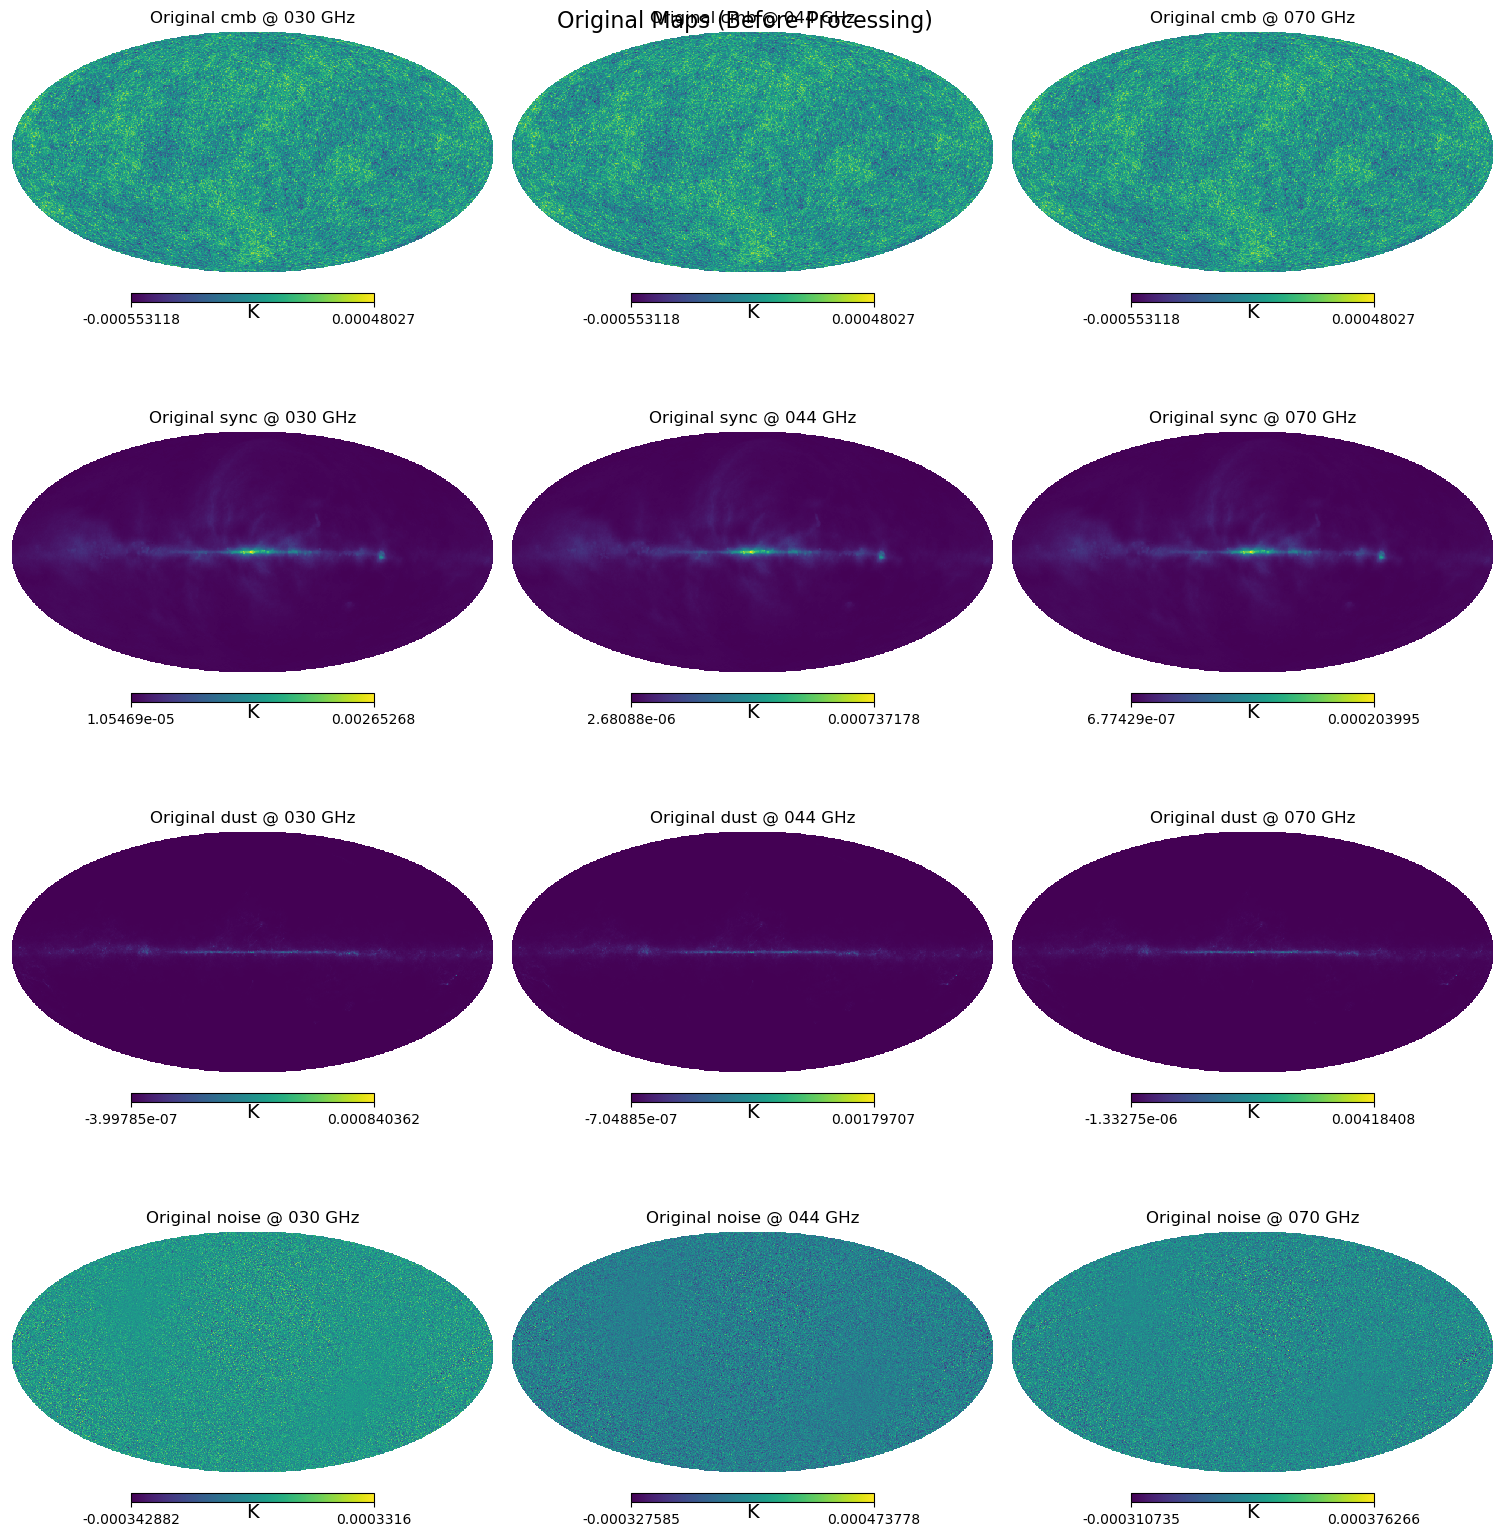


Plotting processed maps...


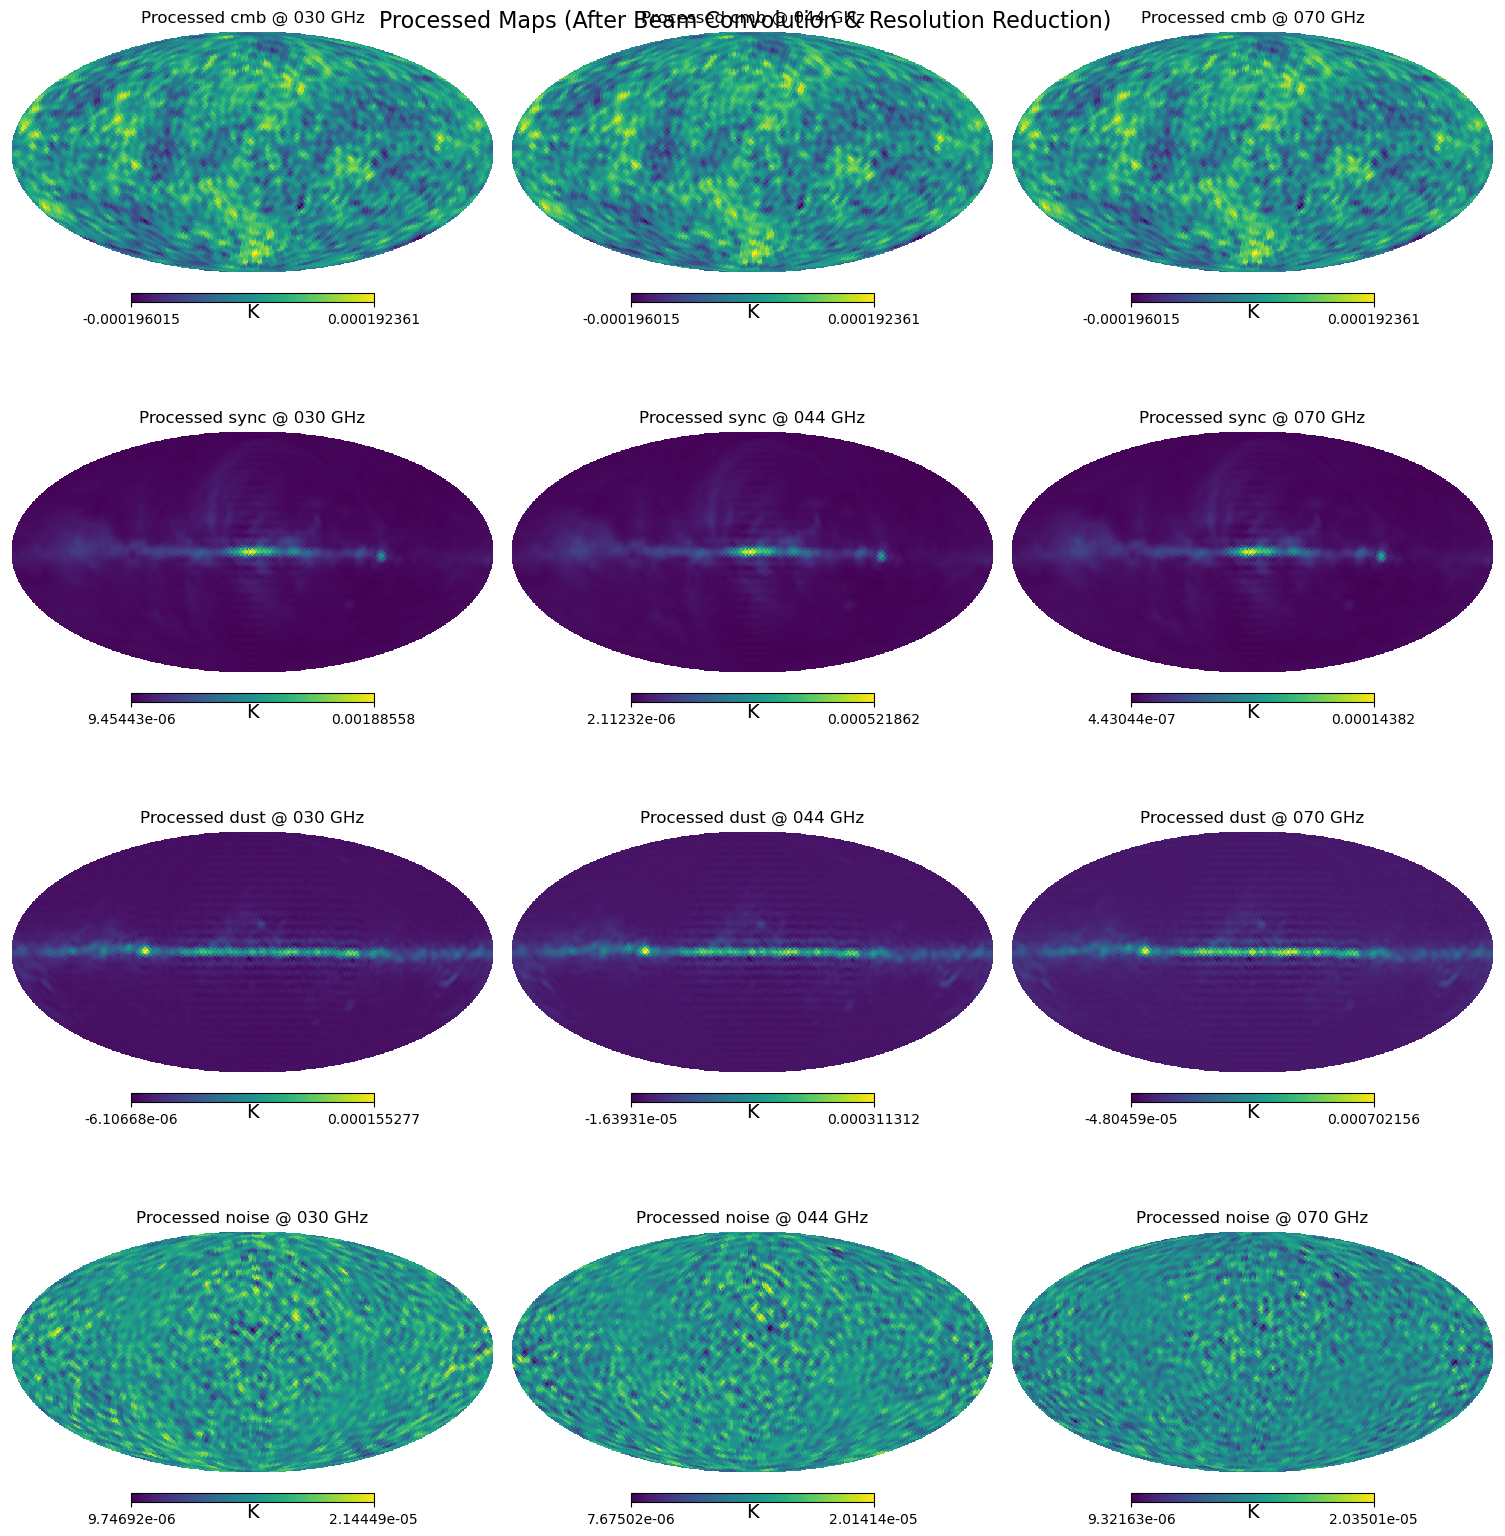


Plotting CFN maps...


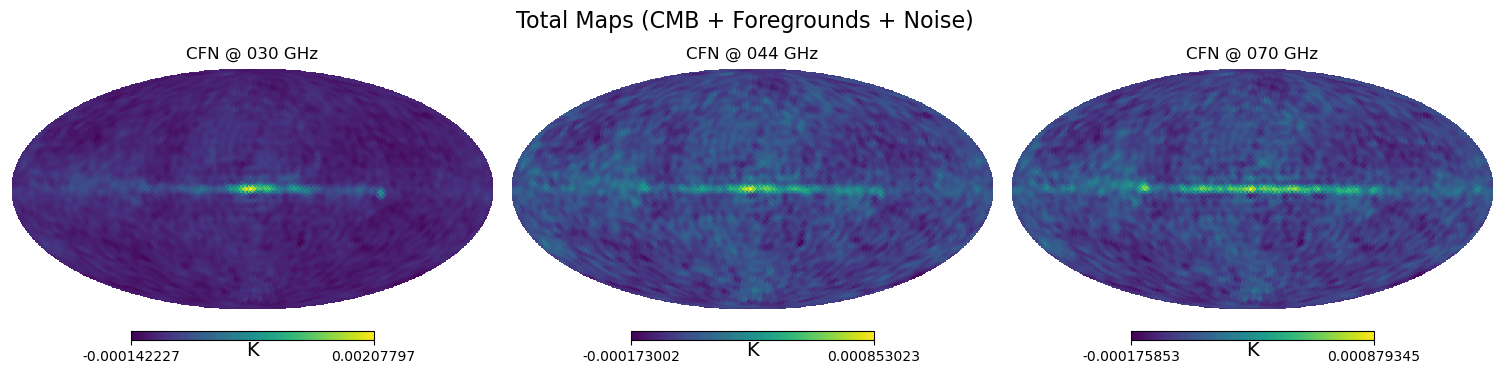


Visualizing MW CFN maps using MWTools...

Plotting CFN @ 030 GHz in MW sampling...


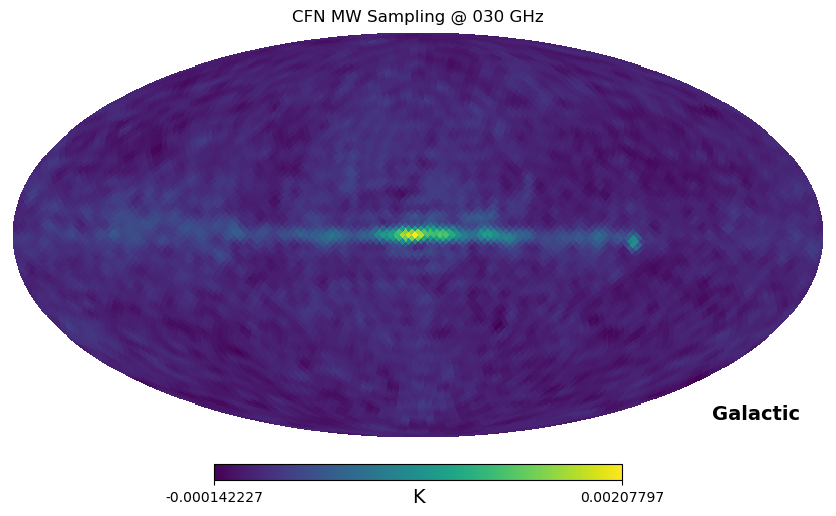


Plotting CFN @ 044 GHz in MW sampling...


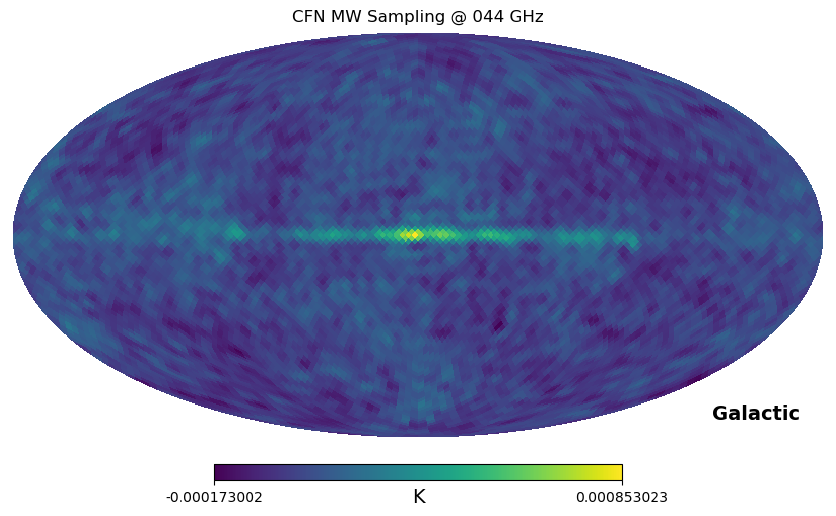


Plotting CFN @ 070 GHz in MW sampling...


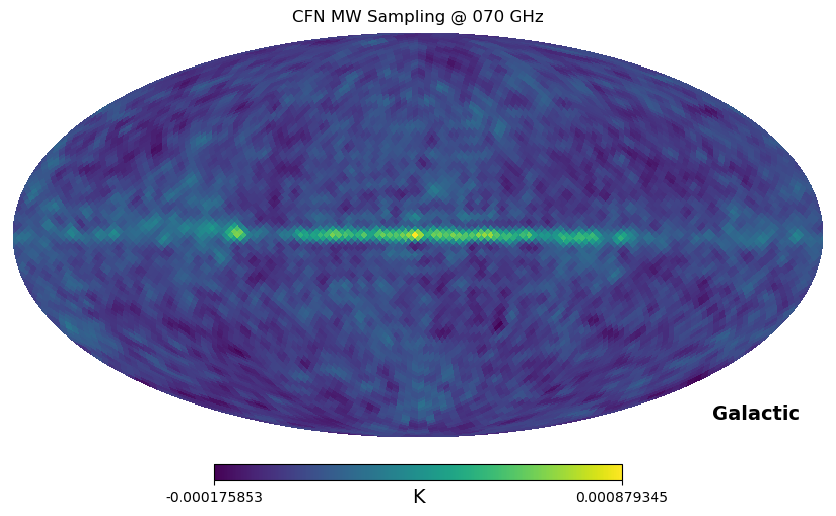


Plotting conversion difference maps...


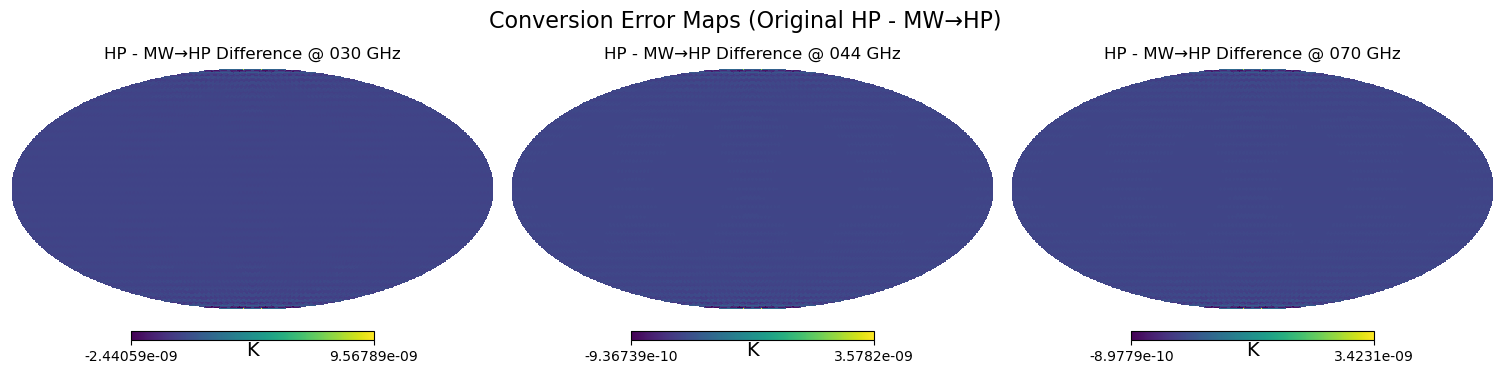


Map processing demonstration complete!
Original resolution: nside=2048
Processed resolution: nside=32
Standard beam applied: 5.0 arcmin FWHM
MW map dimensions: (65, 129)

Clearing variables to free memory...


In [15]:

# Map Processing Example
# This demonstrates the key map processing steps without running the full pipeline


print("Map Processing Parameters:")
print(f"  Components: {components}")
print(f"  Frequencies: {frequencies}")
print(f"  Target lmax: {desired_lmax}")
print(f"  Standard beam FWHM: {np.degrees(standard_fwhm_rad)*60:.1f} arcmin")


# Calculate target nside from lmax
nside = HPTools.get_nside_from_lmax(desired_lmax)
print(f"  Target nside: {nside}")

print("PROCESSING INDIVIDUAL COMPONENTS")

# Store processed maps for visualization
processed_maps = {}
original_maps = {}

for freq in frequencies:
    processed_maps[freq] = {}
    original_maps[freq] = {}
    
    print(f"\nProcessing frequency: {freq} GHz")
    
    for comp in components:
        print(f"  Processing {comp}...")
        filepath = file_templates[comp].format(frequency=freq, realisation=realisation)
    
        original_map = hp.read_map(filepath, verbose=False) # load in the .fits file
        original_maps[freq][comp] = original_map
        
        # Apply unit conversion if needed
        converted_map = HPTools.unit_convert(original_map.copy(), freq)
        
        # Process the map
        if comp == "noise":
            # Noise: only reduce resolution (no beam convolution)
            processed_map, _ = HPTools.reduce_hp_map_resolution(converted_map, lmax=desired_lmax, nside=nside)
            print(f"    - Applied resolution reduction only")
        else:
            # CMB and foregrounds: beam convolution + resolution reduction
            processed_map = HPTools.convolve_and_reduce(converted_map, lmax=desired_lmax, nside=nside, standard_fwhm_rad=standard_fwhm_rad)
            print(f"    - Applied beam convolution and resolution reduction")
        
        processed_maps[freq][comp] = processed_map
        
        # Report statistics
        original_nside = hp.get_nside(original_map)
        print(f"    - Resolution: {original_nside} → {nside} (nside)")
        print(f"    - RMS: {np.std(original_map):.2e} → {np.std(processed_map):.2e}")


print("CREATING TOTAL MAPS (CFN)")
# Create CFN (CMB + Foreground + Noise) maps; this functionality exists in map_processing.py but we will show it explicitly here.
cfn_maps = {}

for freq in frequencies:
    print(f"\nCreating CFN map for {freq} GHz...")
    
    # Initialize empty map
    cfn_map = np.zeros(hp.nside2npix(nside), dtype=np.float64)
    
    # Sum all components
    for comp in components:
        cfn_map += processed_maps[freq][comp]
        print(f"  + Added {comp}")
    
    cfn_maps[freq] = cfn_map
    print(f"  Total RMS: {np.std(cfn_map):.2e}")
    
    # Save CFN map to the standard location (following map_processing.py pattern)
    cfn_filepath = file_templates["cfn"].format(frequency=freq, realisation=realisation, lmax=desired_lmax)
    hp.write_map(cfn_filepath, cfn_map, overwrite=True)
    print(f"  Saved CFN map to: {cfn_filepath}")

print("\nCONVERTING CFN MAPS TO MW SAMPLING")
# Convert HP CFN maps to MW sampling (used for wavelet transforms)
cfn_mw_maps = {}

for freq in frequencies:
    print(f"Converting CFN map to MW sampling for {freq} GHz...")
    
    # Convert HEALPix CFN map to MW sampling
    cfn_mw_map = SamplingConverters.hp_map_2_mw_map(cfn_maps[freq], lmax=desired_lmax)
    cfn_mw_maps[freq] = cfn_mw_map
    
    # Convert back to HP for verification
    cfn_hp_reconstructed = SamplingConverters.mw_map_2_hp_map(cfn_mw_map, lmax=desired_lmax)
    
    # Report conversion statistics
    original_rms = np.std(cfn_maps[freq])
    reconstructed_rms = np.std(cfn_hp_reconstructed)
    conversion_error = np.std(cfn_maps[freq] - cfn_hp_reconstructed)
    
    print(f"  MW map shape: {cfn_mw_map.shape}")
    print(f"  RMS before conversion: {original_rms:.2e}")
    print(f"  RMS after HP→MW→HP: {reconstructed_rms:.2e}")
    print(f"  Conversion error RMS: {conversion_error:.2e}")


print("VISUALISATION")


# Plot original maps (before processing)
print("\nPlotting original maps...")
n_comp = len(components)
n_freq = len(frequencies)

fig = plt.figure(figsize=(5*n_freq, 4*n_comp))
for i, comp in enumerate(components):
    for j, freq in enumerate(frequencies):
        panel = i*n_freq + j + 1
        hp.mollview(
            original_maps[freq][comp],
            fig=fig.number,
            sub=(n_comp, n_freq, panel),
            title=f"Original {comp} @ {freq} GHz",
            unit="K",
            cbar=True
        )
plt.suptitle("Original Maps (Before Processing)", fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# Plot processed maps (after beam convolution and resolution reduction)
print("\nPlotting processed maps...")
fig = plt.figure(figsize=(5*n_freq, 4*n_comp))
for i, comp in enumerate(components):
    for j, freq in enumerate(frequencies):
        panel = i*n_freq + j + 1
        hp.mollview(
            processed_maps[freq][comp],
            fig=fig.number,
            sub=(n_comp, n_freq, panel),
            title=f"Processed {comp} @ {freq} GHz",
            unit="K",
            cbar=True
        )
plt.suptitle("Processed Maps (After Beam Convolution & Resolution Reduction)", fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# Plot CFN maps
print("\nPlotting CFN maps...")
fig = plt.figure(figsize=(5*n_freq, 4))
for j, freq in enumerate(frequencies):
    panel = j + 1
    hp.mollview(
        cfn_maps[freq],
        fig=fig.number,
        sub=(1, n_freq, panel),
        title=f"CFN @ {freq} GHz",
        unit="K",
        cbar=True
    )
plt.suptitle("Total Maps (CMB + Foregrounds + Noise)", fontsize=16, y=0.9)
plt.tight_layout()
plt.show()

# Visualize MW CFN maps using MWTools.visualise_mw_map
print("\nVisualizing MW CFN maps using MWTools...")
for freq in frequencies:
    print(f"\nPlotting CFN @ {freq} GHz in MW sampling...")
    MWTools.visualise_mw_map(
        cfn_mw_maps[freq], 
        title=f"CFN MW Sampling @ {freq} GHz",
        directional=False  # Using directional=False for regular MW maps
    )

# Plot difference maps
print("\nPlotting conversion difference maps...")
fig = plt.figure(figsize=(5*n_freq, 4))
for j, freq in enumerate(frequencies):
    panel = j + 1
    cfn_hp_from_mw = SamplingConverters.mw_map_2_hp_map(cfn_mw_maps[freq], lmax=desired_lmax)
    difference_map = cfn_maps[freq] - cfn_hp_from_mw
    hp.mollview(
        difference_map,
        fig=fig.number,
        sub=(1, n_freq, panel),
        title=f"HP - MW→HP Difference @ {freq} GHz",
        unit="K",
        cbar=True
    )
plt.suptitle("Conversion Error Maps (Original HP - MW→HP)", fontsize=16, y=0.9)
plt.tight_layout()
plt.show()

print("\nMap processing demonstration complete!")
print(f"Original resolution: nside={hp.get_nside(original_maps[frequencies[0]][components[0]])}")
print(f"Processed resolution: nside={nside}")
print(f"Standard beam applied: {np.degrees(standard_fwhm_rad)*60:.1f} arcmin FWHM")
print(f"MW map dimensions: {cfn_mw_maps[frequencies[0]].shape}")

# Clear large variables to prevent memory overload
print("\nClearing variables to free memory...")
del original_maps, processed_maps, cfn_maps, cfn_mw_maps

Loading CFN map for 030 GHz...
Converted CFN @ 030 GHz to MW sampling, shape: (65, 129)

Wavelet Transform Parameters:
Lambda: 4.0
N_directions: 1
L (lmax + 1): 65

AXISYMMETRIC WAVELET FILTER VISUALIZATION
Displaying axisymmetric wavelet filters used in the decomposition...


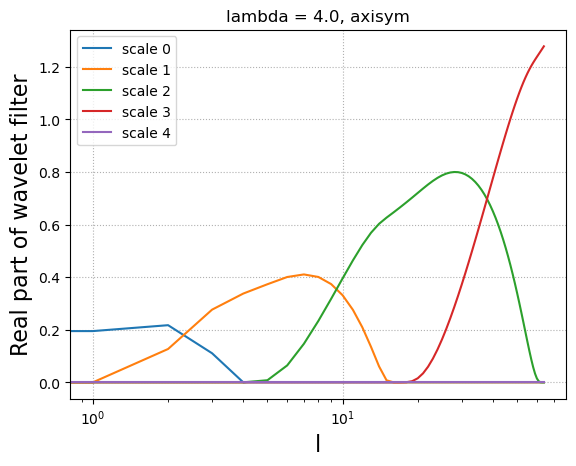


Applying wavelet transform to CFN @ 030 GHz...


(1, 16, 31)
Total number of scales: 6
Components: scale 0 (scaling) + scales 1-5 (wavelets)
Scale 0 (scaling) coefficients shape: (1, 1, 1), effective lmax: 0
Scale 1 (wavelet) coefficients shape: (1, 16, 31), effective lmax: 15
Scale 2 (wavelet) coefficients shape: (1, 16, 31), effective lmax: 15
Scale 3 (wavelet) coefficients shape: (1, 64, 127), effective lmax: 63
Scale 4 (wavelet) coefficients shape: (1, 65, 129), effective lmax: 64
Scale 5 (wavelet) coefficients shape: (1, 65, 129), effective lmax: 64

Original CFN map @ 030 GHz:


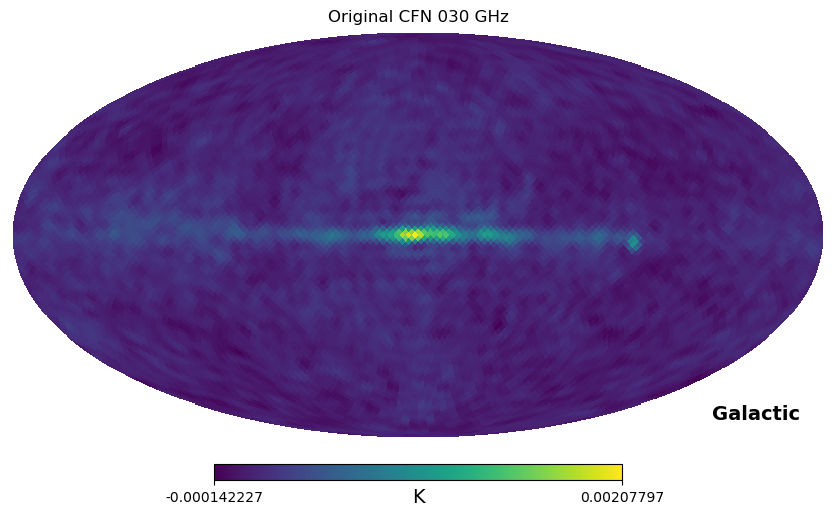


Wavelet decomposition components:
Scale 1 - Wavelet coefficients (lmax=15):


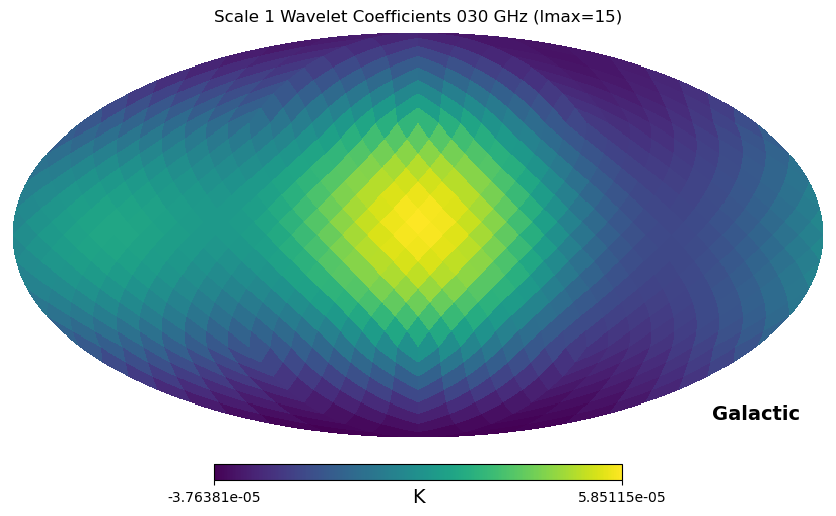

Scale 2 - Wavelet coefficients (lmax=15):


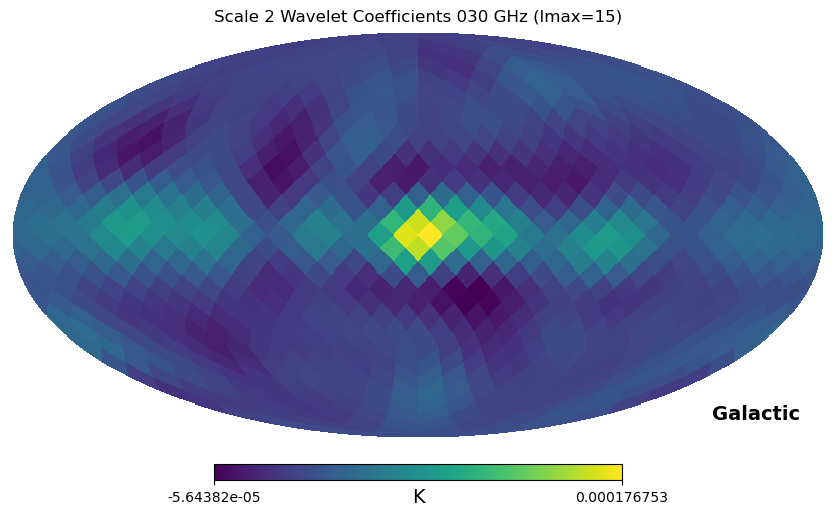

Scale 3 - Wavelet coefficients (lmax=63):


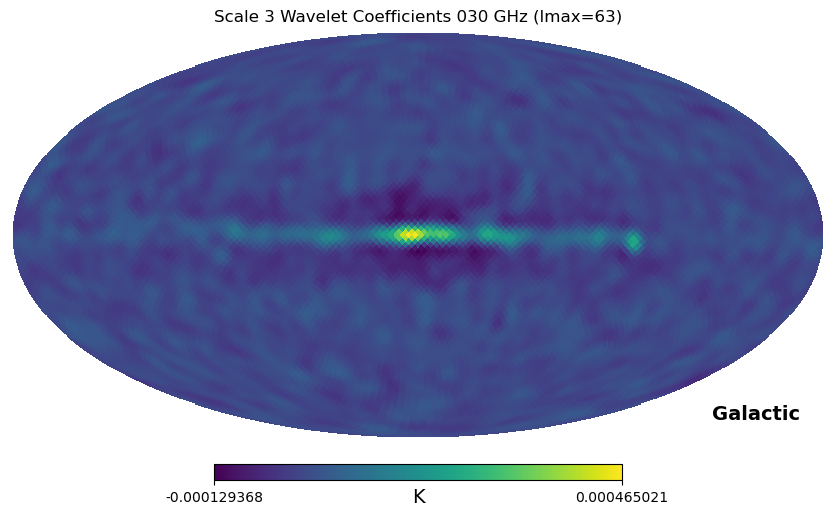

Scale 4 - Wavelet coefficients (lmax=64):


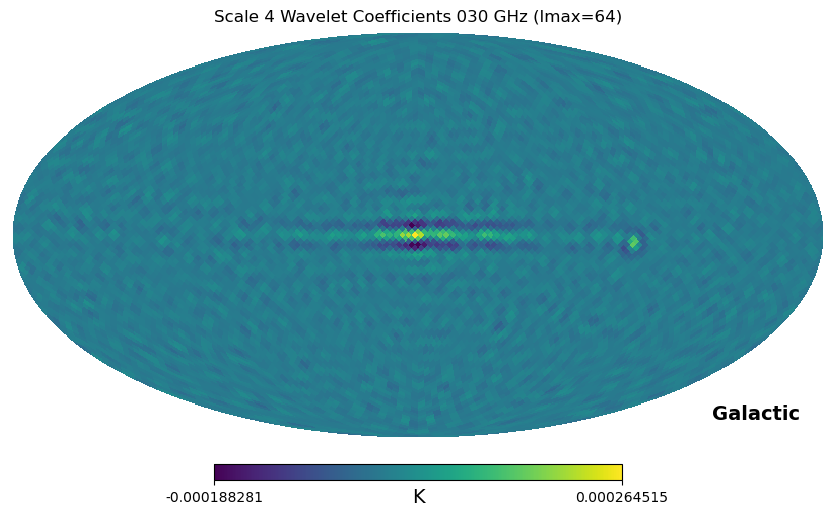

Scale 5 - Wavelet coefficients (lmax=64):


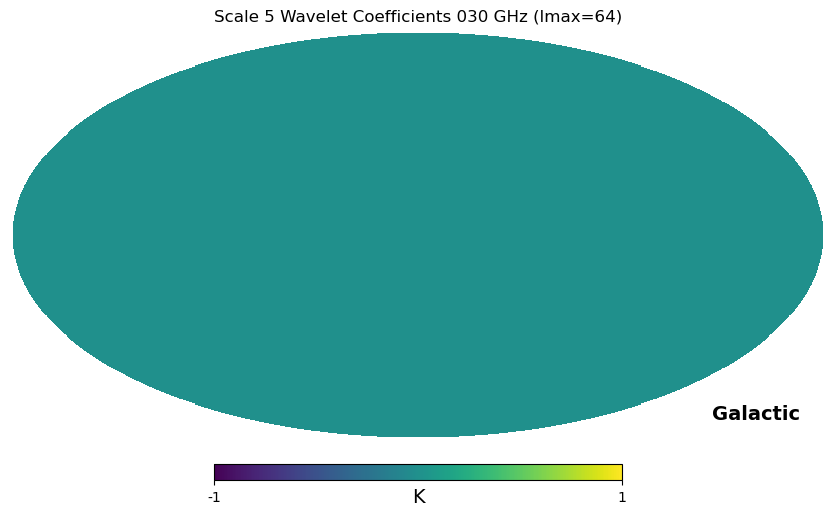


Testing wavelet synthesis (reconstruction)...
(1, 16, 31)
(1, 1, 1)

Reconstructed CFN map:

Reconstructed CFN map:


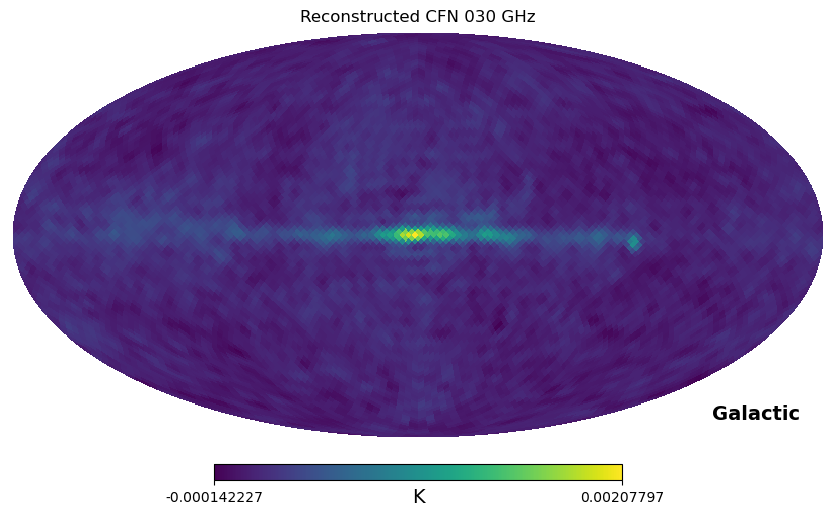


Reconstruction error map:


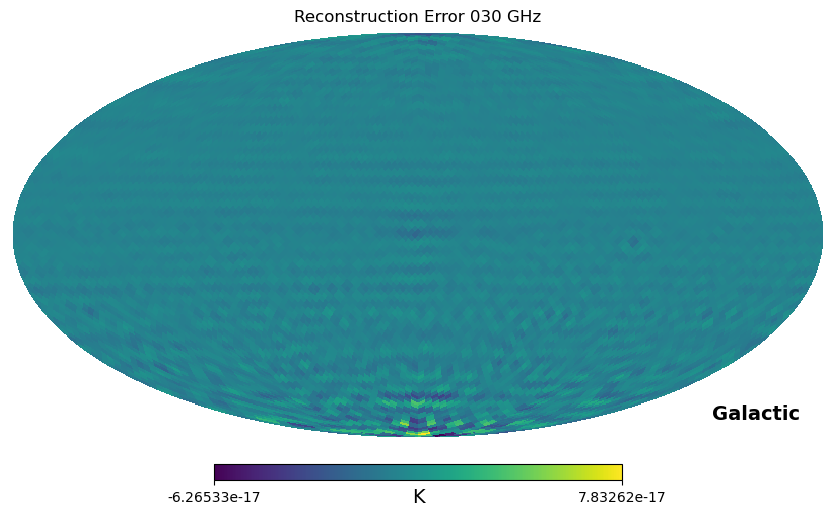

Maximum absolute error: 7.14e-17

Wavelet transform demonstration complete for 030 GHz
Successfully decomposed map into 6 total scales:
  - Scale 0: Scaling coefficients (large-scale structure)
  - Scales 1-5: Wavelet coefficients (progressively finer scales)
Each scale captures different angular scales of the CMB and foreground emission

Clearing variables to free memory...


In [16]:
# Wavelet Transform Demonstration
# Apply multi-scale wavelet transforms to the 030 GHz CFN map

# Load the saved CFN map for 030 GHz
target_freq = "030"
print(f"Loading CFN map for {target_freq} GHz...")

cfn_filepath = file_templates["cfn"].format(frequency=target_freq, realisation=realisation, lmax=desired_lmax)
cfn_map = hp.read_map(cfn_filepath, verbose=False)

# Convert to MW sampling for wavelet transforms
cfn_mw_map = SamplingConverters.hp_map_2_mw_map(cfn_map, lmax=desired_lmax)
print(f"Converted CFN @ {target_freq} GHz to MW sampling, shape: {cfn_mw_map.shape}")

print(f"\nWavelet Transform Parameters:")
print(f"Lambda: {lam}")
print(f"N_directions: {N_directions}")
print(f"L (lmax + 1): {L}")

# WAVELET FILTER VISUALIZATION
print(f"\n" + "=" * 60)
print("AXISYMMETRIC WAVELET FILTER VISUALIZATION")
print("=" * 60)

# Visualize the axisymmetric wavelet filters
print("Displaying axisymmetric wavelet filters used in the decomposition...")
MWTools.visualise_axisym_wavelets(L=L, lam=lam)

# Apply wavelet transform
print(f"\nApplying wavelet transform to CFN @ {target_freq} GHz...")
wavelet_coeffs, _ = MWTools.wavelet_transform_from_map(
    cfn_mw_map, 
    L=L, 
    N_directions=N_directions, 
    lam=lam
)

# Report decomposition structure
n_scales = len(wavelet_coeffs)  # Total number of scales (scaling coeffs = scale 0, then wavelet scales 1, 2, ...)
print(f"Total number of scales: {n_scales}")
print(f"Components: scale 0 (scaling) + scales 1-{n_scales-1} (wavelets)")

for i, coeff in enumerate(wavelet_coeffs):
    scale_lmax = coeff.shape[1] - 1  # MW map shape is (L, 2*L-1), so lmax = L-1
    if i == 0:
        print(f"Scale 0 (scaling) coefficients shape: {coeff.shape}, effective lmax: {scale_lmax}")
    else:
        print(f"Scale {i} (wavelet) coefficients shape: {coeff.shape}, effective lmax: {scale_lmax}")

# Visualize original CFN map in MW sampling
print(f"\nOriginal CFN map @ {target_freq} GHz:")
MWTools.visualise_mw_map(
    cfn_mw_map, 
    title=f"Original CFN {target_freq} GHz",
    directional=False
)

# Visualize all wavelet components (scaling coefficients + wavelet scales)
print(f"\nWavelet decomposition components:")
for scale in range(len(wavelet_coeffs)):
    scale_lmax = wavelet_coeffs[scale].shape[1] - 1
    if scale == 0:
        continue # for some reason scale 0 wont plot
        print(f"Scale 0 - Scaling coefficients (lmax={scale_lmax}):")
        title = f"Scale 0 Scaling Coefficients {target_freq} GHz (lmax={scale_lmax})"
    else:
        print(f"Scale {scale} - Wavelet coefficients (lmax={scale_lmax}):")
        title = f"Scale {scale} Wavelet Coefficients {target_freq} GHz (lmax={scale_lmax})"
    
    MWTools.visualise_mw_map(
        wavelet_coeffs[scale][0],  # First (and only) direction for axisymmetric case
        title=title,
        directional=False
    )

# Test synthesis (reconstruction) from wavelet coefficients
print(f"\nTesting wavelet synthesis (reconstruction)...")
reconstructed_mw = MWTools.inverse_wavelet_transform(
    wavelet_coeffs, 
    L=L, 
    N_directions=N_directions, 
    lam=lam
)

# Visualize reconstructed map
print(f"\nReconstructed CFN map:")
MWTools.visualise_mw_map(
    reconstructed_mw, 
    title=f"Reconstructed CFN {target_freq} GHz",
    directional=False
)

# Compute and visualize reconstruction error
reconstruction_error_mw = cfn_mw_map - reconstructed_mw
print(f"\nReconstruction error map:")
MWTools.visualise_mw_map(
    reconstruction_error_mw, 
    title=f"Reconstruction Error {target_freq} GHz",
    directional=False
)

max_error = np.max(np.abs(reconstruction_error_mw))
print(f"Maximum absolute error: {max_error:.2e}")
print(f"\nWavelet transform demonstration complete for {target_freq} GHz")
print(f"Successfully decomposed map into {n_scales} total scales:")
print(f"  - Scale 0: Scaling coefficients (large-scale structure)")
print(f"  - Scales 1-{n_scales-1}: Wavelet coefficients (progressively finer scales)")
print(f"Each scale captures different angular scales of the CMB and foreground emission")

# Clear large variables to prevent memory overload
print("\nClearing variables to free memory...")
del cfn_map, cfn_mw_map, wavelet_coeffs, reconstructed_mw, reconstruction_error_mw

In [17]:
processor = ProcessMaps(
    components,
    wavelet_components,
    frequencies,
    1,
    start_realisation=0,
    desired_lmax=desired_lmax,
    directory=data_directory,
)
processor.produce_and_save_cfns()

processor.produce_and_save_wavelet_transforms(
        N_directions,
        lam,
    )

# Clear processor to free memory
print("Clearing processor to free memory...")
del processor

CFN map at 030 GHz for realisation 0 already exists. Skipping processing.
CFN map at 044 GHz for realisation 0 already exists. Skipping processing.
CFN map at 070 GHz for realisation 0 already exists. Skipping processing.
Wavelet coefficients for cfn at 030 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 030 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 044 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 044 GHz for realisation 0 saved.
Wavelet coefficients for cfn at 070 GHz for realisation 0 already exist. Skipping generation.
Wavelet transform for cfn at 070 GHz for realisation 0 saved.
Clearing processor to free memory...


## ⚖️ SILC Stage
 
Once decomposing the CFN into wavelet scales, our goal is to perform internal linear combination (ILC) on each scale. An optimisation formula is applied to compute the weighting for each frequency channel that minimises the variance of the foreground and noise. This is subject to the constraint that $\sum_i w_i(p) a_i = 1$ where $i$ are the frequencies, $p$ the pixel, $w_i$ and the weights and $a_i$ is the power spectral density of the component we want to preserve (currently, the CMB, for which $a_i = 1 \forall \, i$). 

First, we run the SILC stage of the pipeline on the GPU using the `ProduceSILC` class. The results should be saved to your data directory such that this only needs to be performed once. Then, we will confirm at an example scale that $\sum_i w_i(p) = 1$ as demanded by the ILC procedure. Next, we will show the ILC synthesised map across the scales. Finally, we will find the spectra of the CMB, CFN and ILC synthesised map. If the procedure is succesful, we expect the ILC power spectrum to be closer to the CMB than the ILC as a function of multipole. However, since the ILC only works up to second order moments. This will build the case for applying an ML enhancement stage, which will be covered in the next notebook. 

In [18]:
# SILC Algorithm - Run the Scale-discretised Internal Linear Combination
print("Setting up SILC parameters...")

# Check what device JAX is using for SILC
print(f"JAX devices available: {jax.devices()}")
print(f"JAX default backend: {jax.default_backend()}")

# Initialize SILC producer
ilc_producer = ProduceSILC(
    ilc_components=["cfn"],  # Process CFN maps to extract CMB
    frequencies=frequencies,
    realisations=1,
    start_realisation=0,
    lmax=desired_lmax,
    N_directions=N_directions,
    lam=lam,
    synthesise=True,
    directory=data_directory,
)

print(f"\nSILC Configuration:")
print(f"  ILC components: {ilc_producer.ilc_components}")
print(f"  Frequencies: {ilc_producer.frequencies}")
print(f"  Realisations: {ilc_producer.realisations}")
print(f"  Lambda: {ilc_producer.lam}")
print(f"  Number of scales: {len(ilc_producer.scales)}")
print(f"  Scales: {list(ilc_producer.scales)}")
print(f"  Method: {ilc_producer.method}")

# Run the SILC pipeline
print("\nRunning SILC pipeline...")
print("This will:")
print("  1. Load wavelet coefficients for each frequency and scale")
print("  2. Double resolution of wavelet maps")
print("  3. Calculate covariance matrices at each scale")
print("  4. Compute ILC weight vectors")
print("  5. Create ILC maps at each scale")
print("  6. Trim back to original resolution")
print("  7. Synthesize final ILC map from all scales")

ilc_producer.process_wavelet_maps(
    save_intermediates=True,  # Save intermediate results for analysis
    visualise=False  # We'll do visualization separately
)

print("\nSILC pipeline complete!")
print("Generated files:")
print("  - Weight vector maps for each scale")
print("  - ILC maps at each wavelet scale")
print("  - Final synthesized ILC map")

# Note: Keep ilc_producer for the next cell's analysis

Setting up SILC parameters...
JAX devices available: [CudaDevice(id=0), CudaDevice(id=1)]
JAX default backend: gpu

SILC Configuration:
  ILC components: ['cfn']
  Frequencies: ['030', '044', '070']
  Realisations: 1
  Lambda: 4.0
  Number of scales: 6
  Scales: [0, 1, 2, 3, 4, 5]
  Method: jax_cuda

Running SILC pipeline...
This will:
  1. Load wavelet coefficients for each frequency and scale
  2. Double resolution of wavelet maps
  3. Calculate covariance matrices at each scale
  4. Compute ILC weight vectors
  5. Create ILC maps at each scale
  6. Trim back to original resolution
  7. Synthesize final ILC map from all scales
Processing realisation 0 for component cfn...
File data/SILC/ilc_synthesised_maps/ilc_synthesised_map_r0000_lmax64_lam4.0.npy already exists. Skipping to the next realisation.

SILC pipeline complete!
Generated files:
  - Weight vector maps for each scale
  - ILC maps at each wavelet scale
  - Final synthesized ILC map


SILC Results Analysis and Visualization
Analyzing scale 3 (middle scale out of 6 total scales)

1. ILC WEIGHT MAP ANALYSIS
Weight vector shape: (127, 253, 3)
Weight vector represents contributions from 3 frequencies

Weight map for 030 GHz:


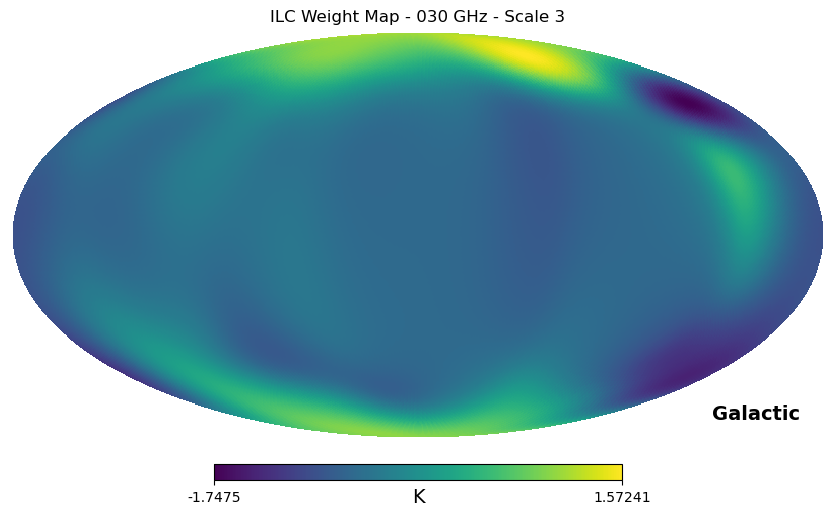


Weight map for 044 GHz:


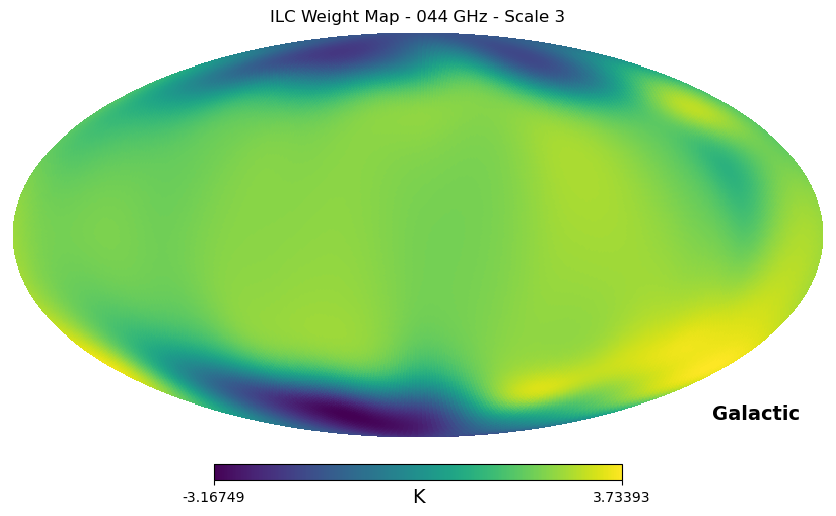


Weight map for 070 GHz:


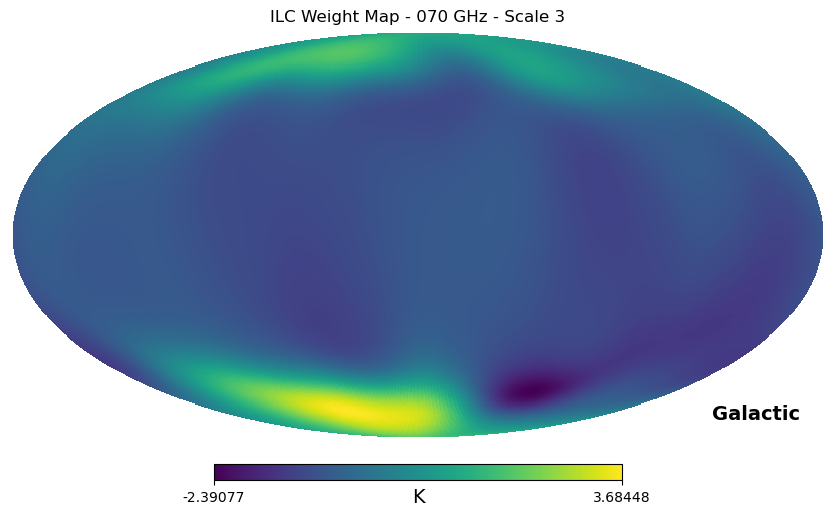


----------------------------------------
2. ILC CONSTRAINT VERIFICATION: Σᵢ wᵢ = 1
----------------------------------------

Weight Statistics:
  Mean weight sum: 1.000000
  Std weight sum: 0.000000
  Min weight sum: 1.000000
  Max weight sum: 1.000000
  Target (ideal): 1.000000

Individual Frequency Weight Statistics:
  030 GHz - Mean: -0.158697, Std: 0.676287
  044 GHz - Mean: 1.193440, Std: 1.776762
  070 GHz - Mean: -0.034743, Std: 1.221002

ILC Constraint Error Analysis:
  Mean absolute error: 9.57e-17
  Max absolute error: 6.66e-16
  Status: EXCELLENT - Constraint satisfied to machine precision

Visualizing weight sum map (should be ≈ 1 everywhere):


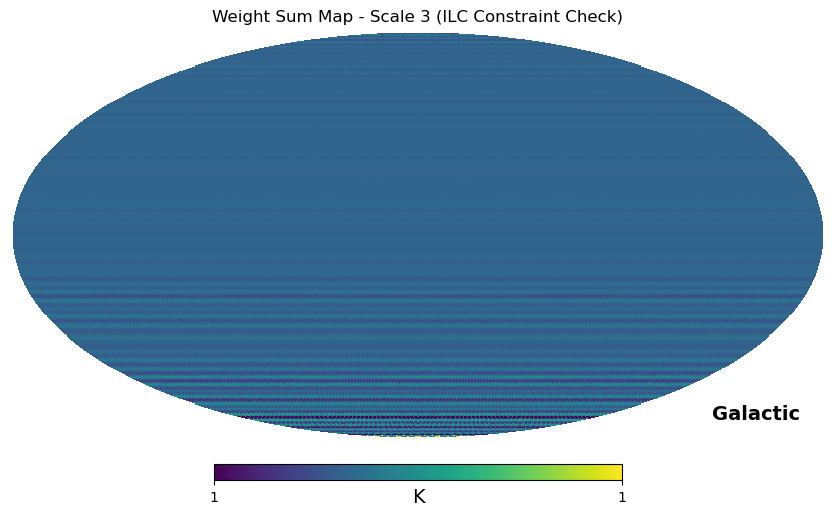


3. ILC SYNTHESISED MAP VISUALIZATION
ILC synthesised map shape: (65, 129)


<Figure size 1200x800 with 0 Axes>

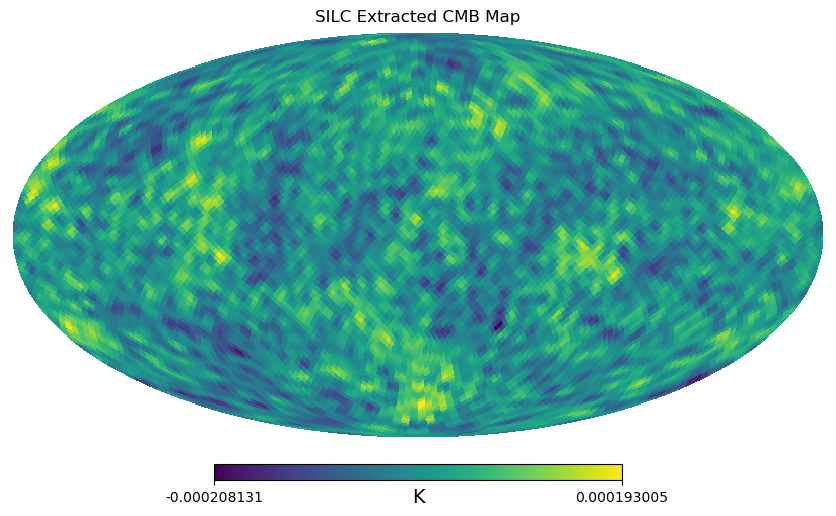


4. POWER SPECTRA ANALYSIS
Plotting power spectra for: ['cmb', 'cfn', 'ilc_synth']
Computing cmb power spectrum from data/CMB_realisations/cmb_r0000.fits...
Computing cfn power spectrum from data/CFN_realisations/cfn_f030_r0000_lmax64.npy...
Loaded existing ilc_synth power spectrum from data/SILC/ilc_synthesised_maps/ilc_synth_power_spectrum_r0000_lmax64_lam4.0.npy
Computing cmb power spectrum from data/CMB_realisations/cmb_r0000.fits...
Computing cfn power spectrum from data/CFN_realisations/cfn_f030_r0000_lmax64.npy...
Loaded existing ilc_synth power spectrum from data/SILC/ilc_synthesised_maps/ilc_synth_power_spectrum_r0000_lmax64_lam4.0.npy
Computing cmb power spectrum from data/CMB_realisations/cmb_r0000.fits...
Computing cfn power spectrum from data/CFN_realisations/cfn_f030_r0000_lmax64.npy...
Loaded existing ilc_synth power spectrum from data/SILC/ilc_synthesised_maps/ilc_synth_power_spectrum_r0000_lmax64_lam4.0.npy
Computing cmb power spectrum from data/CMB_realisations/cmb_r0

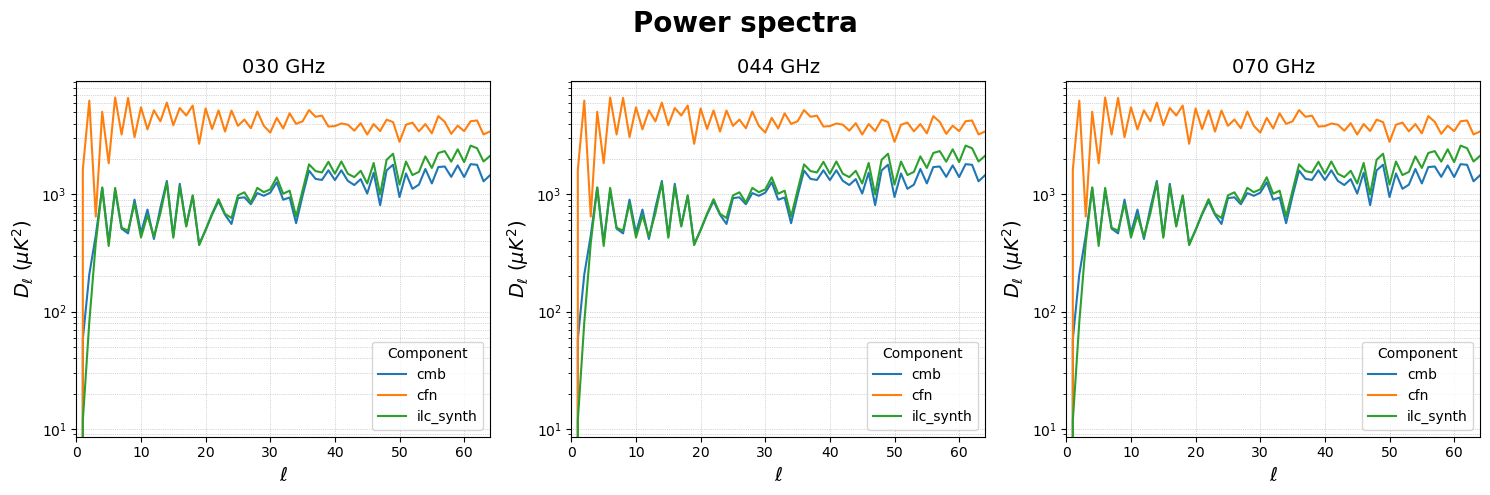


Power spectra analysis complete!
The plots show:
  - CMB: True CMB signal (what we want to recover)
  - CFN: Total observed maps (CMB + Foregrounds + Noise)
  - ILC: SILC-extracted CMB component

Clearing variables to free memory...


In [19]:
# Comprehensive SILC Results Visualization
print("SILC Results Analysis and Visualization")
print("=" * 60)

# Get the middle scale for weight map for an example scale to plot
middle_scale_idx = len(ilc_producer.scales)// 2
middle_scale = list(ilc_producer.scales)[middle_scale_idx]
print(f"Analyzing scale {middle_scale} (middle scale out of {len(ilc_producer.scales)} total scales)")

# 1. WEIGHT MAP ANALYSIS
print("\n" + "=" * 60)
print("1. ILC WEIGHT MAP ANALYSIS")
print("=" * 60)

# Load and visualize weight maps for the middle scale
weight_vector_path = file_templates['weight_vector_matrices'].format(
    scale=middle_scale, 
    realisation=realisation, 
    lmax=desired_lmax, 
    lam=lam
)

if os.path.exists(weight_vector_path):
    weight_vector = np.load(weight_vector_path)
    print(f"Weight vector shape: {weight_vector.shape}")
    print(f"Weight vector represents contributions from {len(frequencies)} frequencies")
    
    # Visualize weight maps for each frequency
    for freq_idx, freq in enumerate(frequencies):
        print(f"\nWeight map for {freq} GHz:")
        MWTools.visualise_mw_map(
            weight_vector[:, :, freq_idx],
            title=f"ILC Weight Map - {freq} GHz - Scale {middle_scale}",
            directional=False
        )
        
    # 2. VERIFY WEIGHT SUM = 1 (ILC constraint)
    print(f"\n" + "-" * 40)
    print("2. ILC CONSTRAINT VERIFICATION: Σᵢ wᵢ = 1")
    print("-" * 40)
    
    # Sum weights across all frequencies
    weight_sum = np.sum(weight_vector, axis=2)
    
    # Calculate weight statistics
    print(f"\nWeight Statistics:")
    print(f"  Mean weight sum: {np.mean(weight_sum):.6f}")
    print(f"  Std weight sum: {np.std(weight_sum):.6f}")
    print(f"  Min weight sum: {np.min(weight_sum):.6f}")
    print(f"  Max weight sum: {np.max(weight_sum):.6f}")
    print(f"  Target (ideal): 1.000000")
    
    # Individual frequency weight statistics
    print(f"\nIndividual Frequency Weight Statistics:")
    for freq_idx, freq in enumerate(frequencies):
        freq_weights = weight_vector[:, :, freq_idx]
        print(f"  {freq} GHz - Mean: {np.mean(freq_weights):.6f}, Std: {np.std(freq_weights):.6f}")
    
    # Check constraint satisfaction
    weight_error = np.abs(weight_sum - 1.0)
    max_error = np.max(weight_error)
    mean_error = np.mean(weight_error)
    
    print(f"\nILC Constraint Error Analysis:")
    print(f"  Mean absolute error: {mean_error:.2e}")
    print(f"  Max absolute error: {max_error:.2e}")
    
    if max_error < 1e-10:
        print(f"  Status: EXCELLENT - Constraint satisfied to machine precision")
    elif max_error < 1e-6:
        print(f"  Status: GOOD - Constraint satisfied within numerical tolerance")
    elif max_error < 1e-3:
        print(f"  Status: ACCEPTABLE - Small constraint violation")
    else:
        print(f"  Status: WARNING - Significant constraint violation")
    
    # Visualize weight sum map to check ILC constraint
    print(f"\nVisualizing weight sum map (should be ≈ 1 everywhere):")
    MWTools.visualise_mw_map(
        weight_sum,
        title=f"Weight Sum Map - Scale {middle_scale} (ILC Constraint Check)",
        directional=False
    )
        
else:
    print(f"Weight vector file not found: {weight_vector_path}")

# 3. ILC SYNTHESISED MAP
print(f"\n" + "=" * 60)
print("3. ILC SYNTHESISED MAP VISUALIZATION")
print("=" * 60)

# Load and visualize the final ILC synthesized map
ilc_synth_path = file_templates['ilc_synth'].format(
    realisation=realisation, 
    lmax=desired_lmax, 
    lam=lam
)

if os.path.exists(ilc_synth_path):
    ilc_synth_map = np.load(ilc_synth_path)
    print(f"ILC synthesised map shape: {ilc_synth_map.shape}")
    
    # Convert to HEALPix for visualization
    if len(ilc_synth_map.shape) == 2:  # MW sampling
        ilc_hp_map = SamplingConverters.mw_map_2_hp_map(ilc_synth_map, lmax=desired_lmax)
    else:  # Already HEALPix
        ilc_hp_map = ilc_synth_map
    
    
    # Visualize ILC map
    fig = plt.figure(figsize=(12, 8))
    hp.mollview(
        ilc_hp_map,
        title="SILC Extracted CMB Map",
        unit="K",
        cbar=True
    )
    plt.show()
    
else:
    print(f"ILC synthesized map not found: {ilc_synth_path}")

# 4. POWER SPECTRA COMPARISON
print(f"\n" + "=" * 60)
print("4. POWER SPECTRA ANALYSIS")
print("=" * 60)

# Initialize visualizer for power spectra
visualiser = Visualise(
    frequencies=frequencies,
    realisation=realisation,
    lmax=desired_lmax,
    lam_list=[lam],
    directory=data_directory
)

# Components to compare: CMB, CFN, and ILC
components_to_plot = ['cmb', 'cfn', 'ilc_synth']
print(f"Plotting power spectra for: {components_to_plot}")

# Visualize power spectra
visualiser.visualise_power_spectra(
    comps=components_to_plot,
)

print("\nPower spectra analysis complete!")
print("The plots show:")
print("  - CMB: True CMB signal (what we want to recover)")
print("  - CFN: Total observed maps (CMB + Foregrounds + Noise)")  
print("  - ILC: SILC-extracted CMB component")

# Clear large variables to prevent memory overload
print("\nClearing variables to free memory...")
if 'weight_vector' in locals():
    del weight_vector
if 'weight_sum' in locals():
    del weight_sum
if 'ilc_synth_map' in locals():
    del ilc_synth_map
if 'ilc_hp_map' in locals():
    del ilc_hp_map
del ilc_producer, visualiser